In [1]:
!pip install git+https://github.com/fastai/fastai.git &> /dev/null

In [2]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

## 00:24:05 - Embeddings for any categorical variable

* Embeddings can handle any type of discrete categorical data: sex, postcode
   * Number of "discrete levels" is called cardinality.
   
## 00:25:01 - Rossman sales competition

* Kaggle competition to predict how many things on each day would be sold.
* One of gold medalisted used Deep Learning: one of the first examples of it in the wild.
  * Wrote a paper: [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737)
* In the paper, they explored the embedding matrix for regions in Germany and found that mapping the embeddings to 2d space, turn out to resemble a map of Germany
* They also compared the distance between stores and the embedding distance between stores, and found a strong correlation.
* Similar for days of week and months of year.

## 00:28:55 - Embeddings at Google Play

* Google wrote a paper called [Wide & Deep Learning for Recommender Systems](https://arxiv.org/abs/1606.07792) which utilised embeddings, as well as continuous features like Age, App installs, engagement sessions.
  * They also performed cross product transformation on the user installed apps and app the user has has impressions for.
  
## 00:30:06 - Other approaches to tabular data

* Deep Learning isn't always the best approach for tabular data.
* An alternative is ensembles of decisions trees (Random Forest and Gradient Boosting Machines)
  * Usually you'll want to "try both"

## 00:31:29 - Question: why does y_range go from 0 to 5.5 (instead of 5)?

* Because Sigmoid function will never reach exactly 5 as it asymptotes. To predict 5, you'll need a number bigger than it.

## 00:32:06 - Question: are embeddings used only for high cardinal variables?

* They can be used for any cardinal variable with 2 or more levels.

## 00:33:03 - Decision Tree ensembles

* The technology has some useful tools for interpreting data and tend to require less hyperparam tuning.
* Jeremy's first approach is to start with a random forest, unless it's high cardinality data.

## 00:34:50 - Scikit-learn

* Popular library for creating non-deep learning ML models.
  * Refered to as sklearn
* Wes McKinney's book has more about Scikit Learn.

## 00:35:30 - Blue Book for Bulldozer's Kaggle competition

* Goal to predict the sale price of heavy equipment.
* Kaggle competitions provide interesting datasets, good feedback, leaderbords and blog posts that share teaching.

## 00:37:02 - Exploring the dataset

* Can download Kaggle data using the API, however, in this example I have it attached to the kernel.
* The main table is `train.csv`
* Contains:
  * `SalesID` - unique id of sale
  * `MachineID` - unique id of machine
  * `saleprice` - what machine sold at auction
  * `saledate` - date of the sale.

In [3]:
df = pd.read_csv('../input/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False)

In [4]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

## 

* First thing to look at is ordinal columns. Things you know are discrete values that have an order.
* Can tell Pandas about suitable ordering with categorical values with `ordered=True`

In [5]:
df.ProductSize.unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [6]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

In [7]:
df['ProductSize'] = df.ProductSize.astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

* Need to set dependant variable, which is the log of the sale price.

In [8]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

## 00:40:14 - Understanding Decision Trees

* Decision Trees asks a series of binary (yes/no) questions about data.
* Since we don't know what binary questions to ask, we need to find a way to automate that.
* Simple procedure for doing it:
  1. Loop through each column of dataset
  2. For each column, loop through each possible level (ie item in category)
  3. Split data into 2 groups, based on if less/greater than value or equal or not equal if categorical.
  4. Find the average sale price for each group and see how close to actual label.
  5. After looping through all columns and levels, find split point that gives best predictions.
  6. For each dataset in the split point, perform steps 1-5.
  7. Continue until you reach a stopping criteria - like when a group only has 20 items in it.

## 00:44:57 - Handling dates

* To take advantage of dates, fastai's `add_datepart` function expands date columns into more columns.
  * An example of [[Feature Engineering]]

In [9]:
df = add_datepart(df, 'saledate')

In [10]:
df_test = pd.read_csv('../input/bluebook-for-bulldozers/Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [11]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

## 00:45:58 - Cleaning strings and missing data

* Two `TabularProc`s are used: `Categorify` and `FillMissing`
  * Like a `Transform` but with 2 differences:
    * Modifies object in-place to save memory
    * Runs transform once when data is first passed in
* `Categorify` replaces column with numerical categorical column.
* `FillMissing` - add `is_missing=True` as separate column and settings missing values to the mean.



In [12]:
procs = [Categorify, FillMissing]

## 00:47:31 - Validation set for time series

* Since it's a timeseries, a random validation set isn't going to be approriate.
  * You'll want to use the model in the future: not a date in the past.
* Test set is 2 weeks of data after the data in training set.
  * We should therefore do the same for valid (make last couple of weeks of data).

In [13]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits= (list(train_idx), list(valid_idx))

## 00:48:46 - Data processing continued

* Separate continuous and categorical variables: `cont_cat_split` does this for you

In [14]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

* `TabularPandas` behaves like fastai `Datasets` object:

In [15]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [16]:
len(to.train), len(to.valid)

(404710, 7988)

In [17]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


## 

* `.show` shows you the text representation. Under the hood, the data is represented by integers:

In [18]:
to.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


* Can save using the `save_pickle` function:

In [19]:
save_pickle('to.pkl',to)

* And load with `load_pickle`

In [20]:
to = load_pickle('to.pkl')

## 00:50:55 - Create a decision tree

* Use a `DecisionTreeRegressor` when the depedant variable is continuous:

In [21]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [22]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

* We can see what is learned using `draw_tree` function

In [23]:
from sklearn.tree import export_graphviz
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

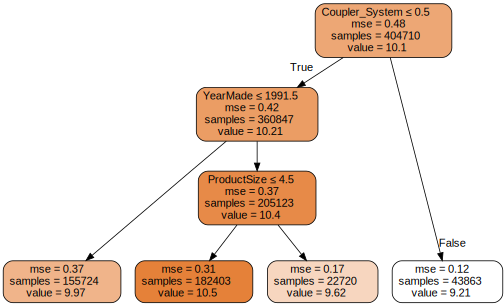

In [24]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

* To train it further, you can use a higher number of leaf nodes.

## 00:56:32 - dtreeviz

* A library by Terrance Parr for visualising Decision Trees.
* Looking at the YearMade value, we can see that there are a number values for `YearMade` as 1000.

## 00:57:57 - Building a bigger decision tree

* We can remove `max_leaf_nodes` and train a bigger model:

In [25]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

* Now to evaluate with mse.

In [26]:
def r_mse(pred, y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

In [27]:
m_rmse(m, xs, y)

0.0

* Model appears to be perfect. However, we should check the val set to see if we're overfitting:

In [28]:
m_rmse(m, valid_xs, valid_y)

0.331901

* The reason is because we have a number of lead nodes close to the training set.

In [29]:
m.get_n_leaves(), len(xs)

(324599, 404710)

* We can add a new stop criteria to stop splitting once leaf node has 25 samples

In [30]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.211677, 0.267995)

In [31]:
m.get_n_leaves()

12397

* How can we get the best of booth worlds? Build really deep trees that don't overfit? Bagging...

## 01:00:42 - Categorical variables revisited

* You usually don't need to one-hot encoded categorical variables with decision trees normally, as it has capability to split on a single "level".

## 01:30:39 - Bagging

* To improve Decision Tree, you'll use a small technical report called [Bagging Predictors](https://link.springer.com/article/10.1023/A:1018054314350) by Leo Breiman.
* He described "Bootstrap replicates", which is a subset of the training dataset.
* The steps are as follows:
  * Randomly choose a subset of the rows of your data ("bootstrap replicates of your learning set")
  * Train model on subset
  * Save model and return to step 1 a few times.
  * Predict using all models, then take the average of each models predictions.
  
## 01:06:22 - Random Forest

* Breiman developed a variation of this approach, where he would also select a subset of columns randomly when making binary splits. Called [[Random Forest]]

In [32]:
def rf(
    x, y, n_estimators=40, max_samples=200_000,
    max_features=0.5, min_samples_leaf=5, **kwargs
):
    return RandomForestRegressor(
        n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples,
        max_features=max_features, min_samples_leaf=min_samples_leaf,
        oob_score=True
    ).fit(x ,y)

m = rf(xs, y)

* `n_jobs=-1` - use all CPU cores you have.
* `n_estimators` - how many trees / models to train
* `max_samples` - how many rows to use for each tree.
* `max_features` - how many randomly chosen columns to use for each split point.
* `min_samples_leaf` - stopping criteria

In [33]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170846, 0.233481)

* It's often quite hard to improve on this model - with Random Forests, the defaults turns out to be quite good.

## 01:08:58 - Analysing Random Forests

* Docs have lots of information about how n_estimators improves error rates.
  * Generally more trees = more accurate models.
* Can access underlying Decision Trees via `estimators_`

In [34]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [35]:
r_mse(preds.mean(0), valid_y)

0.233481

* Can visualise how much adding more models to the ensemble helps with our rmse:

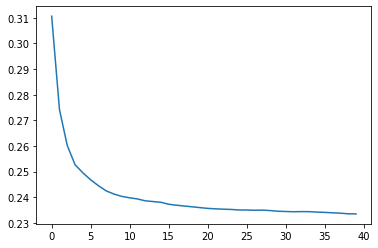

In [36]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

## 01:11:20 - Out-of-bag error

* Is the validation set worse than the training set because we're over-fitting?
  * Can out out-of-bag error to find out.
* How it works:
  * Each tree is trained on a subset of the data. For each tree, calculate validation predictions on the rows that weren't included.
  * Like validation with a validation set

In [37]:
r_mse(m.oob_prediction_, y)

0.210668

## 01:14:09 - Model interpretation

* 5 things we usually want to know about a model:
  * How confident are we with a particular row of data?
  * For predicting a particular item, which factors were most important? 
  * Which columns are most important? Which can we ignore?
  * Which columns are effectively redundant with each other?
  * How do predictions vary as we vary these columns?
  
## 01:15:14 - Tree variance for prediction confidence
  
* We've already seen that we can take the mean of all predictions for all trees.
* We can also take the std. This will give us an indication of which rows some of the trees didn't agree on.

In [38]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [39]:
preds_std = preds.std(0)

In [40]:
preds_std[:5]

array([0.2572597 , 0.09731126, 0.11276323, 0.2582181 , 0.14091749])

* We may decide that predictions that have wild disagreement amongst the model we should be more cautious of.

## 01:16:47 - Feature importance

* The features that are most strongly driving the independant variable.

In [41]:
def rf_feat_important(m, df):
    return pd.DataFrame({
        'cols': df.columns, 'imp': m.feature_importances_
    }).sort_values('imp', ascending=False)

In [42]:
fi = rf_feat_important(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.182894
6,ProductSize,0.122876
30,Coupler_System,0.090795
7,fiProductClassDesc,0.076804
32,Hydraulics_Flow,0.058711
54,ModelID,0.058263
65,saleElapsed,0.050424
3,fiSecondaryDesc,0.041631
31,Grouser_Tracks,0.040883
1,fiModelDesc,0.032942


* We can also plot them:

<AxesSubplot:ylabel='cols'>

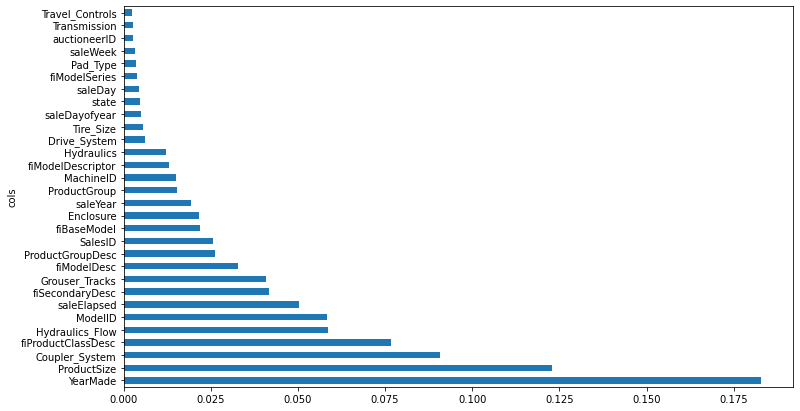

In [43]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

plot_fi(fi[:30])

* How it works:
  * Loop through each tree and explore each branch.
  * What feature / column was used to split? How much better after split?
  * Add up the amount of improvement for each column at each split and normalise so all add to one.
  * That gives you the feature importance weight.

## 01:18:53 - Remove low-importance features

* We may decide to remove the less important features. The ones less than 0.005 importance.

In [44]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

21

* Can then retrain model using just this subset of columns

In [45]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [46]:
m = rf(xs_imp, y)

In [47]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181207, 0.230759)

* Our accuracy is pretty close.
* With only 21 columns, it's a lot easier for us to understand what the model is doing and to "fit it in our heads"

<AxesSubplot:ylabel='cols'>

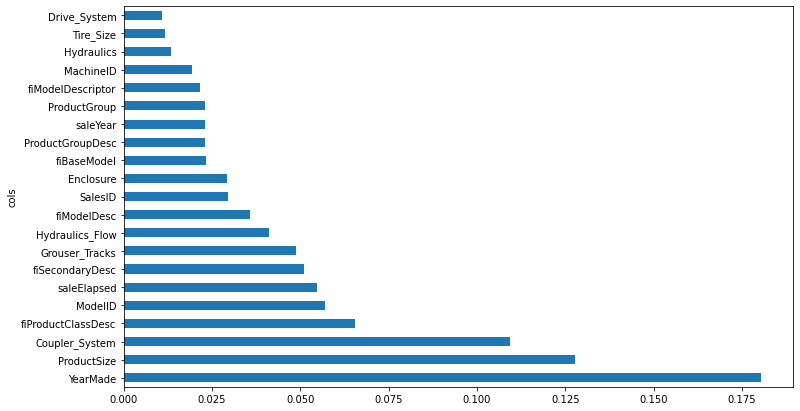

In [48]:
plot_fi(rf_feat_important(m, xs_imp))

* We can see from this plot that there are some features that have similar importance.

## 01:20:42 - Remove redundant features

* Can use fastai's `cluster_columns`

In [49]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

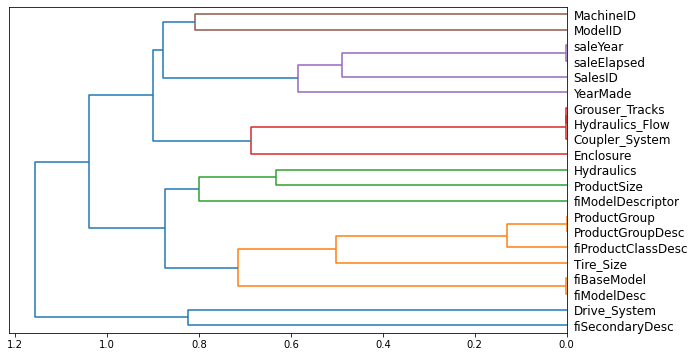

In [50]:
cluster_columns(xs_imp)

* Will find pairs of columns that are similar.
* Noting that some columns are way out to the right, like `saleYear` and `saleElapsed`
  * When one is low, the other tends to be.

* We can write a function that trains on a subset of rows, for performance reasons.

In [51]:
def get_oob(df):
    m = RandomForestRegressor(
        n_estimators=40, min_samples_leaf=15, max_samples=50000,
        max_features=0.5, n_jobs=-1, oob_score=true)
    m.fit(df, y)
    return m.oob_score_

In [52]:
get_oob(xs_imp)

0.8770968462086648

* Now remove each variable one at a time:

In [53]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc', 'ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System'
)}

{'saleYear': 0.8764087968944265,
 'saleElapsed': 0.8725683520015458,
 'ProductGroupDesc': 0.8767291716802044,
 'ProductGroup': 0.8771671162078598,
 'fiModelDesc': 0.8759015665441356,
 'fiBaseModel': 0.8759546821890264,
 'Hydraulics_Flow': 0.87703832041101,
 'Grouser_Tracks': 0.8775237626485679,
 'Coupler_System': 0.8774153908030318}

* There appears to be 5 variables that we don't need.

In [54]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8741397127277142

* It's pretty similar to model with all the fields.

In [55]:
xs_final = xs_imp.drop(to_drop,axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [56]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183177, 0.232413)

## 01:24:13 - Partial dependence

* The next thing to learn about, for the columns that are most important, what is relationship between that column and 

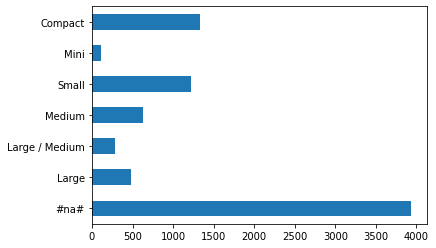

In [57]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c)
plt.show()

* Can do the same thing for `YearMade` but have to make a histogram:

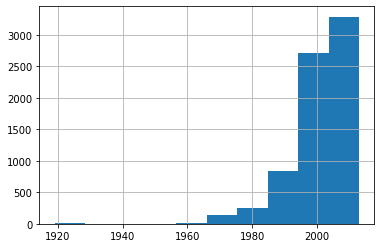

In [58]:
ax = (valid_xs_final['YearMade'][valid_xs_final['YearMade'] > 1000]).hist()

* We can look at a partial dependance plot.
  * As YearMade increases, the predicted sale price also increases:

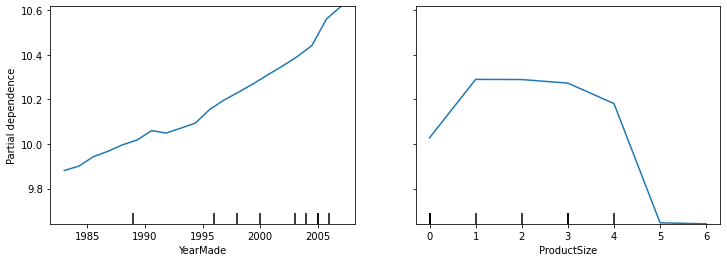

In [59]:
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final[valid_xs_final['YearMade'] > 1000], ['YearMade', 'ProductSize'],
                       grid_resolution=20, ax=ax)

* Can see there's a clear relationship between YearMade and sale price.
* Want to answer the question: all other things being equal, how does `YearMade` impact results?
* How it works:
  * In our dataset, replace all values with 1950 and take the average.
  * Then do that for all YearMade values.
  * Then plot the results.
* For the productsize example, the lowest costs are apparently the ones with no size label.
  * We'd want to learn why that is.

## 01:29:29 - Tree interpreter

* Last question to answer: for predictions from a single row of data, what are the most important factors that influence the decision?
  * Can use treeinterpreter

In [60]:
!pip install treeinterpreter  &> /dev/null
!pip install waterfallcharts  &> /dev/null

* Works similar to computing feature importance:
  * Put row of data through first decision tree and see what split is used at each point.
  * For each split, can see what increase or decrease in prediction.
  * Do for every tree and add total chainge in importance.

In [61]:
row = valid_xs_final.iloc[:5]

In [62]:
from treeinterpreter import treeinterpreter
import waterfall_chart

prediction, bias, contributions = treeinterpreter.predict(m, row.values)

* `prediction` is the prediction the RF makes.
* `bias` is the prediction based on taking the mean of dependant variable.
* `contributions` tells total change in prediction due to indepedant variables.
  * sum of contributions + bias should be equal to prediction.

In [63]:
prediction[0], bias[0], contributions[0].sum()

(array([10.01493858]), 10.104455112013337, -0.08951653563792852)

* Can then plot it like this:

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

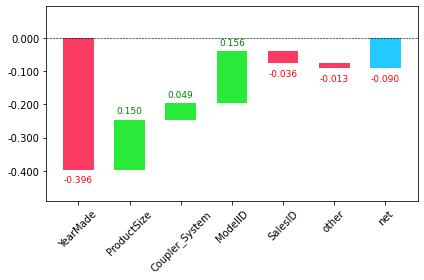

In [64]:
waterfall_chart.plot(
    valid_xs_final.columns, contributions[0], threshold=0.08,
    rotation_value=45, formatting='{:,.3f}')

* Start at 0, which is the average log sale price of whole dataset (they call the bias).
  * YearMade makes the prediction lower.
  * ProductSize has positive influence.
  * Couple_System has positive influence.
  * ModelID has positive.
  * fiModelDesc positive.
  * etc
* Useful in production, as it can help you understand why predictions are being made.

## 01:34:05 - Extrapolation

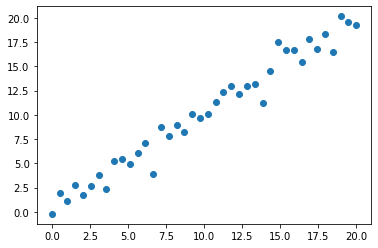

In [65]:
np.random.seed(420)

x_lin = torch.linspace(0, 20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin)

* We only have one dependant variable, PyTroch expects a matrix. So we can use `unsqueeze` to add a dimension. Change from `[40]` to `[40, 1]`

In [66]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

* Can also achieve this with the special value `None`:

In [67]:
x_lin[:,None].shape

torch.Size([40, 1])

* Can create a Random Forest for the first 30 data points:

In [68]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

* test the model on the entire dataset:

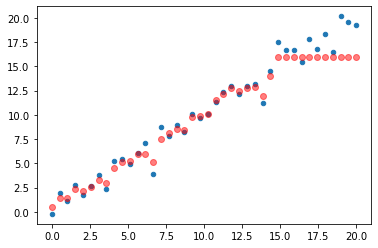

In [69]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5)

* The Random Forest is unable to extrapolate outside of bounds of data from training set.
* Therefore, we need to ensure that our validation set doesn't contain [[Out-of-Domain]] data.

## 01:37:41 - Finding out of domain data

* Technique known as [[Adversarial Validation]].
* Can use a random forest to prediction whether data is in validation or test set.

In [70]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0] * len(xs_final) + [1] * len(valid_xs_final))

m = rf(df_dom, is_valid)

* We can use feature importance to see what's driving the difference:

In [71]:
rf_feat_important(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.872770
9,SalesID,0.085393
12,MachineID,0.037327
10,Enclosure,0.000926
0,YearMade,0.000847
16,Tire_Size,0.000720


* `saleElapsed` is clear, as that's how we split the train and valid set.
* `SalesID` and `MachineID` are likely not random and increase over time.
* What happens if we remove those columns from the model?

In [72]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID', 'saleElapsed', 'MachineID'):
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y))

orig 0.232839
SalesID 0.23163
saleElapsed 0.235513
MachineID 0.231471


* Looks like we can remove `SalesID` and `MachineID` without losing accuracy.

In [73]:
time_vars = ['SalesID', 'MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229917

* What's more, the model will be more resiliant over time.
* We can also see that the sales for the model are mostly in the last year:

<AxesSubplot:>

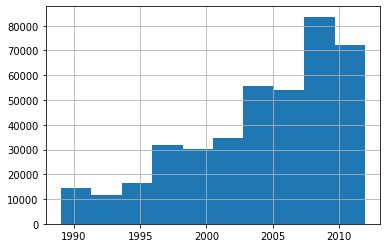

In [74]:
xs['saleYear'].hist()

In [75]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

* Results of training on a subset:

In [76]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.17773, 0.229867)

* The issue of extrapolation doesn't happen with a neural network, as it's using linear layers.

## 01:42:26 - Question: how does feature importance relate to correlation?

* It doesn't particularly relate.
* Correlation is used more with linear models.

## 01:43:29 - Using an NN

In [77]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'
dep_var = 'SalePrice'

In [78]:
path = Path('../input/bluebook-for-bulldozers')
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')    

* Can leverage the work to trim unwanted columsn in Random Forest by using same set of columns for neural network:

In [79]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

* Categorical columns are handled differently in neural networks.
* To create embeddings, need to know which columns should be categorical.
* We'll say that if a column has < 9k variables, we'll say it's categorical.

In [80]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [81]:
cont_nn

['saleElapsed']

* One variable that we don't want to treat as categorical is `saleElapsed`, since we're planning to  extrapolate outside of bounds of dataset.

In [82]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
Hydraulics_Flow          3
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

* Can see that `ModelID` and `ModelDesc` seem to have similar cardinality. See we can likely remove one.

In [83]:
cat_nn.remove('fiModelDescriptor')

* With a neural network, we're required to normalize the data before inputting it. This isn't required with a random forest.

In [84]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(
    df_nn_final, procs_nn, cat_nn, cont_nn,
    splits=splits, y_names=dep_var
)

In [85]:
dls = to_nn.dataloaders(1024)

* Good idea to set `y_range` for regression models, find the min and max of dependant variables

In [86]:
y = to_nn.train.y
y.min(), y.max()

(8.465899467468262, 11.863582611083984)

* Can create a `Learner` for a tabular model.
* We are increasing default layer size to 500 from 250.

In [87]:
from fastai.tabular.all import *

In [88]:
learn = tabular_learner(
    dls, y_range=(8, 12), layers=[500, 200], n_out=1, loss_func=F.mse_loss)

/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0002290867705596611)

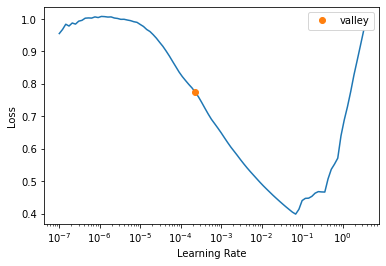

In [89]:
 learn.lr_find()

In [90]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.062133,0.077527,00:29
1,0.053659,0.054414,00:28
2,0.047735,0.053346,00:29
3,0.042538,0.051281,00:29
4,0.040002,0.051087,00:29


In [91]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.226024

* Slightly better than our Random Forest.

## 01:49:19 - Ensembling

* The Random Forest and neural network both are good and bad at some things.
* Ensemble gives us "best of both worlds".
* Easiest is to just take the average:

In [92]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) / 2

* We do even better:

In [93]:
r_mse(ens_preds, valid_y)

0.222395

## 01:51:26 - Boosting

* How boosting works:
  * Train small model that under fits dataset.
  * Calculate predictions using small model.
  * Subtract predictions from targets: called "residuals".
    * Represents error for each point in training set.
  * Go to step one, instead of ordinal targets use residuals as target for training
  * Continue doing this until you reach a stopping criterion, like max trees or validation set gets worse.
  * Then, add results of model together (not average).
* Lot of varients of this: Gradient Boost machines (GBMs) and gradient boosted decision trees (GBDTs)
* In this approach, each new tree attempting to fit the error of all previous trees combined.

## 01:53:23 - Question: is dropping features better than regularisation for overfitting?

* Removing columns isn't to avoid overfitting - it's to simplify the model.
  * It will mean less trees, but it doesn't mean regularisation.
  
## 01:54:14 - Question: is there a heuristic for picking number of layers in linear model?

* Not really. 2 is a good start.

## 01:55:00 - Boosting continued

* There's nothing to stop the model from overfitting, unlike a Random Forest where more trees means better performance.
  * Use regularisation.
* More often win Kaggle competitions than Random Forests do.

## 01:56:02 - Combining embeddings with other methods

* From Entity Embeddings paper.
* They build NN and got entity embeddings.
* Used a random forest using embeddings as predictors.

## 01:57:44 - Conclusion